In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".4"

import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad, vmap
import optax
import distrax

from neuron import h
_ = h.load_file("stdlib.hoc")

from neurax.integrate import solve
from neurax.cell import Cell, equal_segments, linear_segments, _compute_num_kids, _compute_index_of_kid, compute_levels, compute_branches_in_level
from neurax.stimulus import Stimulus, step_current
from neurax.recording import Recording
from neurax.connection import Connection, Connectivity
from neurax.utils.plot_utils import plot_morph
from neurax.mechanisms.hh_neuron import hh_neuron_gate
from neurax.mechanisms.glutamate_synapse import glutamate
from neurax.cell import merge_cells
from neurax.utils.swc import read_swc, _split_into_branches, _build_parents, _extract_endpoint_radiuses, _compute_pathlengths

In [4]:
device_str = "cpu"
jax.config.update('jax_platform_name', device_str)

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

device = cpus[0] if device_str == "cpu" else gpus[0]

### Hyperparameters

In [5]:
nseg_per_branch = 4

r_a = 5_000  # ohm cm 
i_delay = 3.0  # ms
i_amp = 5.0  # nA
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 10.0  # ms


### Morphology

In [6]:
nseg_per_branch = 4

parents = [-1, 0, 1, 2]
parents = jnp.asarray(parents)

lengths = [80.0, 10.0, 2.0, 2.0]
endpoint_rads = [10.0, 5.0, 4.0, 8.0]

num_branches = len(parents)
ncomp = num_branches * nseg_per_branch

lengths = equal_segments(lengths, nseg_per_branch)
radiuses = equal_segments(endpoint_rads, nseg_per_branch)

cell1 = Cell(num_branches, parents, nseg_per_branch, lengths, radiuses, r_a)

recs = [
    Recording(0, 0, 0.0),
    Recording(0, 3, 1.0),
    Recording(0, 0, 1.0),
]

In [7]:
cell1.branch_conds_fwd

Array([  533.33333333,  7619.04761905, 12800.        ], dtype=float64)

### Run

In [8]:
# Initialize voltage
init_v = [
    jnp.asarray([-62.0] * num_branches*nseg_per_branch), 
]

# Initialize states
hh_states = [
    jnp.stack(
        [
            jnp.asarray([0.074901] * num_branches*nseg_per_branch), 
            jnp.asarray([0.4889] * num_branches*nseg_per_branch),
            jnp.asarray([0.3644787] * num_branches*nseg_per_branch),
        ]
    ),
]

### Set up model

In [9]:
time_vec = jnp.arange(0.0, t_max+dt, dt)

In [10]:
cells = [cell1]
conns = [Connection(0, 0, 0.0, 0, 1, 0.0)]
connectivities = [Connectivity(conns, nseg_per_branch)]
stims = [Stimulus(0, 0, 0.0, current=step_current(i_delay, i_dur, i_amp, time_vec))]

### Define parameters

In [11]:
hh_params = [
    jnp.stack(
        [
            jnp.asarray([0.12] * num_branches*nseg_per_branch), 
            jnp.asarray([0.036] * num_branches*nseg_per_branch),
            jnp.asarray([0.0003] * num_branches*nseg_per_branch),
        ]
    ),
]

synapse_params = jnp.asarray([0.0] * len(conns))

### ODE

In [12]:
mem_channels = [hh_neuron_gate,]
mem_states = [hh_states,]
mem_params = [hh_params,]

In [13]:
syn_channels = [glutamate,]
syn_states = [jnp.zeros((len(conns))),]
syn_params = [synapse_params,]

In [14]:
# with jax.disable_jit():
s = solve(
    cells,
    connectivities,
    init_v,
    mem_states=mem_states,
    mem_params=mem_params,
    mem_channels=mem_channels,
    syn_states=syn_states,
    syn_params=syn_params,
    syn_channels=syn_channels,
    stimuli=stims,
    recordings=recs,
    t_max=t_max,
    dt=dt,
    solver="thomas",
    checkpoint_inds=[]
)

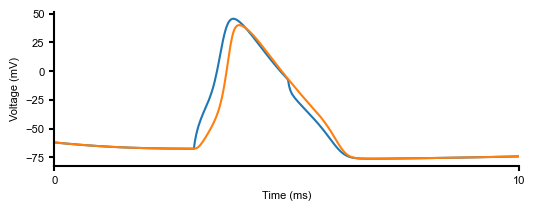

In [15]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    for i in range(2):
        _ = ax.plot(time_vec, s[i])
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xticks([0, max(time_vec)])
    ax.set_xlim([0, max(time_vec)])
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

In [16]:
s[1][::30]

Array([-62.        , -64.65065038, -66.37102246, -67.22379634,
       -67.48797528,  12.46903364,  20.29739233, -17.82339236,
       -55.90238527, -76.16215618, -75.928326  , -75.51670258,
       -75.00084274, -74.38119959], dtype=float64)

In [17]:
s[0][::30]

Array([-62.        , -64.65065038, -66.37102246, -67.22379634,
       -67.48797528,  42.59724115,  17.83997934, -27.08875563,
       -62.58737402, -76.17656039, -75.93922056, -75.52786032,
       -75.01180182, -74.39158722], dtype=float64)